# 신경망 학습

In [1]:
# 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import sys
import os

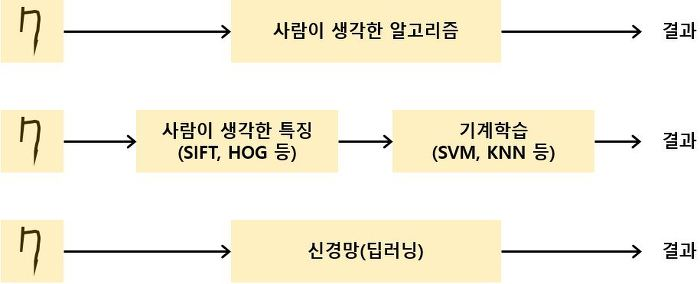

데이터를 이용해 결과를 내는 세 가지 방법

두 번째 방법에서는 접근 방법을 사람이 설정

신경망은 입력 데이터에 어떤 특징이 중요한지도 기계가 학습한다. (가중치를 수정해가면서)

따라서 end-to-end 라고도 한다.

# 손실 함수

In [2]:
# 오차제곱합
def sum_squares_error(y, t): 
    return 0.5 * np.sum((y-t)**2)

# 원 핫 인코딩
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 정답 2

# 신경망의 출력 2인 경우
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(sum_squares_error(np.array(y), np.array(t)))

# 신경망의 출력이 7인 경우
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(sum_squares_error(np.array(y), np.array(t)))

0.09750000000000003
0.5975


교차 엔트로피에 로그 이유
https://gooopy.tistory.com/63

In [3]:
# 교차 엔트로피
def cross_entropy_error(y, t):
    delta = 1e-7 # log에 0 이 입력되는 사태 방지
    return -np.sum(t * np.log(y + delta)) 

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099338
2.302584092994546


In [4]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from dataset.mnist import load_mnist

# 0.0~1.0 으로 정규화한 데이터로 받아온다.
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# flatten의 default값이 True
print(x_train.shape)
# one_hot_label True
print(t_train.shape, '\n')

(60000, 784)
(60000, 10) 



In [5]:
train_size = x_train.shape[0] # 60000
batch_size = 10 
batch_mask = np.random.choice(train_size, batch_size)
print(batch_mask)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

# 10장의 데이터인지 확인
print(x_batch.shape) # (10,784)
print(t_batch.shape) # (10,10)

[ 3051 16231 18059 28877 42750  8196 28262 28346 51393 39646]
(10, 784)
(10, 10)


In [6]:
# 0 이상 60000 미만의 수 중에서 무작위로 10개 골라낸 것을 반환
print(np.random.choice(60000, 10))

[26279 50297  1903 33572  3865 25686 38588  6460 23595 51514]


In [7]:
# 미니배치를 위한 교차 엔트로피 오차 구현

# Case 1 : 정답 레이블이 원-핫 인코딩인 경우
def cross_entropy_error(y, t):   # y : 신경망 출력, t : 정답 레이블
    if y.ndim == 1:    # y가 1차원이다 => 데이터 하나당 교차 엔트로피 오차를 구한다 의 경우
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    delta = 1e-7
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

In [8]:
# Case 2 : 정답 레이블이 단순 레이블 형태인 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [9]:
# 단순 레이블(원핫 인코딩 아니고, 2, 7 등)일 때 왜 저렇게 표현할 수 있나?
t = [2, 3]
y = np.array([ [0.1, 0.05, 0.5, 0.1, 0.05, 0.1, 0.0, 0.05, 0.05, 0.0],
               [0.1, 0.0,  0.0, 0.7, 0.0, 0.1, 0.0,  0.05,  0.05, 0.0] ] ) # 2,10

batch_size = y.shape[0] # 2
result = y[np.arange(batch_size), t]
print(result)
result = np.log(y[np.arange(batch_size), t] + 1e-7)
print(result)

[0.5 0.7]
[-0.69314698 -0.3566748 ]


  정확도를 놔두고 '손실함수' 를 사용하는 이유 => 미분
  - 우리 목적은 '높은 정확도'를 끌어내는 매개변수(가중치, 편향)을 찾는거임
  - 미분 값을 근거로 매개변수의 값을 갱신하면서 찾을 수 있음
  - 근데 정확도를 지표로 삼고 미분하면 대부분 장소에서 0 이 되기 떄문에 찾기 힘들다.

# 수치 미분

미분을 구현해보자

아래의 코드는 나쁜 예시다. 이유는:

- h 값이 너무 작아 반올림 오차가 발생한다.

- 전방 차분을 사용한다.

In [10]:
# 나쁜 구현 예
def numerical_diff(f,x):
    h = 10e-50 # 작은 값 넣고 싶어서 10e-50
    return (f(x+h)-f(x) / h)



개선방안:
- h = $10^{-4}$
- 중앙 차분 $\frac{f(x+h)-f(x-h)}{2*h}$

In [11]:
# 개선된 구현
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

$y = 0.01x^2 + 0.1x$
에 대해 위의 수치 미분을 사용해보자.

In [12]:
def function_1(x):
    return 0.01*(x**2) + 0.1*x

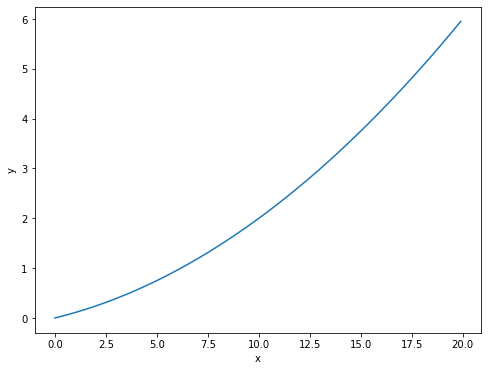

In [13]:
x = np.arange(0,20, 0.1) # 0~19.9
y = function_1(x)

plt.figure(figsize=(8,6))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.show()

해석적 해 : $\frac{dy}{dx} = 0.02x + 0.1$

5를 대입하면 0.2, 10을 대입하면 0.3

In [14]:
print(numerical_diff(function_1,5))
print(numerical_diff(function_1,10))

0.1999999999990898
0.2999999999986347


========== x = 5 인 경우 ===========
수치 미분 결과 : 0.1999999999990898
========== x = 10 인 경우 ==========
수치 미분 결과 : 0.2999999999986347


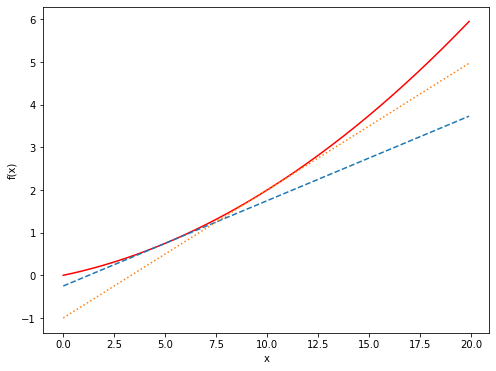

In [15]:
# 수치미분 결과를 기울기로하는 직선 그리기
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(f'수치 미분 결과 : {d}')
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1) # 0~19.9
y = function_1(x)
print('========== x = 5 인 경우 ===========')
tf = tangent_line(function_1, 5)
y2 = tf(x)
print('========== x = 10 인 경우 ==========')
tf = tangent_line(function_1, 10)
y3 = tf(x)
print('===================================')
plt.figure(figsize=(8,6))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y, 'r')
plt.plot(x, y2,'--')
plt.plot(x, y3,':')
plt.show()

편미분 

$f(x_0,x_1) = {x_0}^2 + {x_1}^2$

In [16]:
# 행렬로 표현 가능, 구현
def function_2(x):
    #return x[0]**2 + x[1]**2
    return np.sum(x**2)

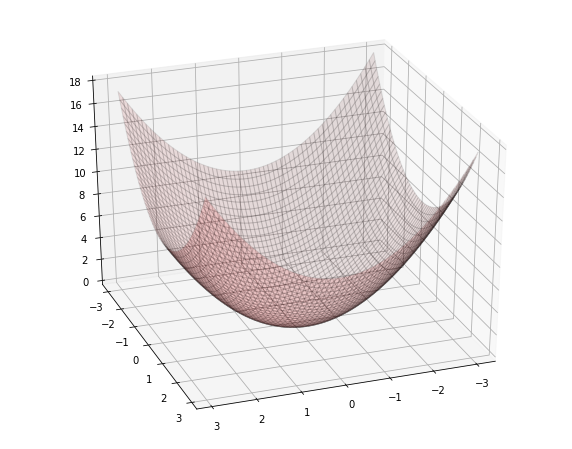

In [17]:
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(-3,3,0.1)
x2 = np.arange(-3,3,0.1)
x1,x2 = np.meshgrid(x1,x2)
y = x1**2 + x2**2

plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1,projection = '3d')
ax.plot_surface(x1, x2, y, rstride = 1,cstride = 1,alpha = 0.1,color = 'red',edgecolor = 'black') 
ax.view_init(30,70)

plt.show()

편미분 

$f(x_0,x_1) = {x_0}^2 + {x_1}^2$ 식에서

(1) $x_0$에 대한 미분

(2) $x_1$에 대한 미분

In [18]:
def function_tmp1(x0): # x0 관련 변수만 남겨놓음
    return x0*x0 + 4.0**2.0

def function_tmp2(x1): # x1 관련 변수만 남겨놓음
    return 3.0**2.0 + x1*x1

print(numerical_diff(function_tmp1, 3.0))
print(numerical_diff(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


# 기울기

모든 변수의 편미분을 벡터로 정리한 것을 기울기(gradient)라고 하면

위의 예시에서 기울기는 $(\frac{\partial{f}}{\partial{x_0}},\frac{\partial{f}}{\partial{x_1}})$ 로 표현할 수 있다.

In [19]:
# 기울기 구현
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # x와 shape이 같으면서 원소가 모두 0인 배열

    for idx in range(x.size):
        tmp_val = x[idx] # 기존의 x값

        x[idx] = tmp_val+h # x+h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val-h # x-h
        fxh2 = f(x) # f(x-h)

        grad[idx] = (fxh1 - fxh2) / (2*h) # f(x+h) - f(x-h) / 2h
        x[idx] = tmp_val # 기존의 x값으로 돌려놓음

    return grad

In [20]:
grad = numerical_gradient(function_2, np.array([3.0, 4.0]))
print(grad)

grad = numerical_gradient(function_2, np.array([0.0, 2.0]))
print(grad)

grad = numerical_gradient(function_2, np.array([3.0, 0.0]))
print(grad)

[6. 8.]
[0. 4.]
[6. 0.]


No handles with labels found to put in legend.


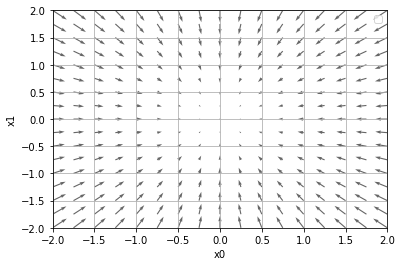

In [21]:
# 기울기의 결과에 마이너스를 붙인 벡터를 시각화
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from ch04 import gradient_2d
from ch04.gradient_2d import numerical_gradient
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)
    
X = X.flatten()
Y = Y.flatten()
    
grad = numerical_gradient(function_2, np.array([X, Y]) )
    
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()

< 경사법 GM, Gradient Method>

경사법에는 최솟값을 찾는 경사 하강법, 최댓값을 찾는 경사 상승법이 있다.

수식으로 표현하면 아래와 같다.


$x_0 = x_0 - \eta\frac{\partial{f}}{\partial{x_0}}$

$x_1 = x_1 - \eta\frac{\partial{f}}{\partial{x_1}}$

$\eta$는 learning rate, 학습률을 나타냄 lr이라고 부르겠음

벡터 기울기는 편미분으로 정해지고,

이 전의 그림에서 비유하자면

- $\eta$ 가 크면  -------------> 

- $\eta$ 가 작으면  -->

그럼 무조건 크다고 좋은가? 갱신을 확확 하니까? 그건 아님

In [22]:
# 경사하강법 GD 구현
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    # f는 우리가 최적화 하려는 함수, init_x는 x의 초기값, lr은 학습률, step_num은 반복 횟수, 훈련 횟수
    x = init_x # 초기값

    for i in range(step_num): # 반복 횟수만큼
        grad = numerical_gradient(f, x) # 편미분해서 기울기를 찾아주고
        x -= lr * grad # x를 갱신해준다.
    
    return x

이렇게 찾은 값을 사용하면 함수의 극솟값일 수도 있고, 최솟값일 수도 있다.

한번 예시 ( $f(x_0,x_1) = {x_0}^2 + {x_1}^2$ )를 통해 확인 해보자.

이 예시에서 learning rate가 무조건 크거나, 무조건 작거나가 좋은 게 아님을 확인

In [23]:
# 함수 먼저 정의
def function_2(x):
    #return x[0]**2 + x[1]**2
    return np.sum(x**2)

# learning rate = 0.1 일 때
init_x = np.array([-3.0, 4.0]) # 초기 값
result_x = gradient_descent(function_2, init_x = init_x, lr= 0.1) # step_num 설정 안하고 default값 그대로 사용

print(f'경사하강법의 결과 X : {result_x}')
print()
print(f'{function_2(result_x)}') # 거의 0

경사하강법의 결과 X : [-6.11110793e-10  8.14814391e-10]

1.0373788922158197e-18


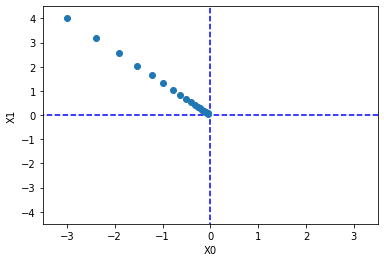

<module 'gradient_method' from '/content/drive/MyDrive/deep-learning-from-scratch-master/ch04/gradient_method.py'>

In [24]:
# x1, x0 값의 변화를 그려보자
path = '/content/drive/MyDrive/deep-learning-from-scratch-master/ch04'
os.chdir(path)
sys.path.append(os.chdir)
import gradient_method
gradient_method

In [25]:
# learning rate = 10.0 일 때 (큰 값)
init_x = np.array([-3.0, 4.0]) # 초기 값
result_x = gradient_descent(function_2, init_x = init_x, lr= 10.0) # step_num 설정 안하고 default값 그대로 사용

print(f'경사하강법의 결과 X : {result_x}')
print()
print(f'{function_2(result_x):.5f}')

경사하강법의 결과 X : [-2.58983747e+13 -1.29524862e+12]

672403483014660368763977728.00000


In [26]:
# learning rate = 1e-10 일 때 (작은 값)
init_x = np.array([-3.0, 4.0]) # 초기 값
result_x = gradient_descent(function_2, init_x = init_x, lr= 1e-10) # step_num 설정 안하고 default값 그대로 사용

print(f'경사하강법의 결과 X : {result_x}')
print()
print(f'{function_2(result_x):.5f}')

경사하강법의 결과 X : [-2.99999994  3.99999992]

25.00000


위의 $\eta$ 즉, learning rate (lr) 같은 사람이 직접 정해줘야 하는 값을 

'하이퍼 파라미터 (hyper parameter)' 라고 부른다.

이제 신경망으로 돌아가서 얘기를 해봅시다.

위의 $x_0, x_1$ 같은 값처럼 학습 때 마다 바꿔줘야 하는 게 뭔가?

앞 장에서 말했지만 가중치와 편향이다. 편향을 일단 뺴고 (편향은 $W_0$ 처럼 포함하면 됨) 얘기해봅시다.

ex) 가중치 $W$ 손실함수 $L$이 있다고 하자.

기울기(Gradient)는? $\frac{\partial L}{\partial W}$로 나타난다. 수식으로 표현해보자.

$W = 
\begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{pmatrix}$

$\frac{\partial L}{\partial W} = 
\begin{pmatrix}
\frac{\partial L}{\partial W_{11}} & \frac{\partial L}{\partial W_{12}} & \frac{\partial L}{\partial W_{13}} \\
\frac{\partial L}{\partial W_{21}} & \frac{\partial L}{\partial W_{22}} & \frac{\partial L}{\partial W_{23}}
\end{pmatrix}$


$\frac{\partial L}{\partial W}$ 의 각 원소는 각각의 원소에 대한 편미분을 나타낸다. 

1행 1열의 원소를 예시로 들면 

가중치 $w_{11}$값의 변화량에 따른 손실 함수 $L$의 변화량이다.

간단한 신경망을 예로 들어서 확인해보자.

In [27]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet(object):
    def __init__(self):
        self.W = np.random.randn(2,3) # 가중치를 (2,3) 형상의 정규분포로 초기화

    def predict(self, x): # 추론
        return np.dot(x, self.W)

    def loss(self,x,t): # loss function
    # x는 입력 데이터, t는 정답 라벨
        z = self.predict(x) # 추론
        y = softmax(z) # softmax
        loss = cross_entropy_error(y,t) # 크로스 엔트로피 오차를 구함
        
        return loss

In [28]:
net = simpleNet()
print(net.W) # 가중치 매개변수 확인

[[-0.29295034  1.5839359   0.59170169]
 [-1.66696076 -0.02078606  2.35369447]]


In [29]:
X = np.array([0.6,0.9])
p = net.predict(X) # XW
print(p) # 0.6[w11 w12 w13] + 0.9[w21 w22 w23]
print(np.argmax(p)) # 가장 큰 값의 인덱스

[-1.67603489  0.93165409  2.47334604]
2


In [30]:
t = np.array([0, 0, 1]) # 정답은 2번째 인덱스
print(net.loss(X, t)) # 정답을 맞췄으면 작게 나올거고 정답과 틀리게 예측했으면 크게 나온다.

0.20684562843454304


In [31]:
f = lambda W: net.loss(X,t)

dW = numerical_gradient(f, net.W) # loss function L을 W의 각 원소에 대해 편미분
print(dW)

[[ 0.00769602  0.10441693 -0.11211295]
 [ 0.01154402  0.15662539 -0.16816942]]


# 학습 알고리즘 구현

2층 신경망 클래스를 구현

아래에서 코드 중 
weight_init_std * np.random.randn(...) 이 어떤 의미인가.

정규분포는 2개의 매개 변수 평균:$\mu$, 표준편차:$\sigma$에 의해 모양이 결정된다. 이때의 분포를 $N(\mu,\sigma^2)$ 로 표기한다.

평균이 1, 표준편차가 0인 정규분포를 표준 정규분포(standard normal distribution)이라고 한다.


numpy의 random.randn() 함수는 표준정규분포로부터 샘플링된 난수를 반환하는데, 표준 정규분포가 아닌 $N(\mu,\sigma^2)$ 형태의 난수를 생성하기 위해서는

$\sigma$ * np.random.randn(...) + $\mu$와 같은 형태로 사용한다.


In [32]:
# TwoLayerNet 구현 (Hidden Layer 1개)
path ='/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet(object):
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x): # 추론
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2) # 이전의 구현과는 달리 추론 과정에 softmax함수까지 사용, loss 과정에서 사용안해도 된다.

        return y

    def loss(self, x, t): # loss function
        y = self.predict(x)
        return cross_entropy_error(y, t)
         
    def accuracy(self,x,t): # AUC
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)  

        accuracy = np.sum(y==t) / float(x.shape[0]) # 정답 수 / 입력 수
        return accuracy

    def numerical_gradient(self, x, t): # 수치 미분 방식으로 매개변수 기울기 구하기
        loss_W = lambda W: self.loss(x,t)

        grads = {} # 기울기
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t): # 5장에서 확인 할, 오차역전파법을 사용한 기울기 계산
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [33]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10) # TwoLayerNet의 인스턴스 net 

print(f"W1의 형태 : {net.params['W1'].shape}")
print(f"b1의 형태 : {net.params['b1'].shape}")
print(f"W2의 형태 : {net.params['W2'].shape}")
print(f"b2의 형태 : {net.params['b2'].shape}")

W1의 형태 : (784, 100)
b1의 형태 : (100,)
W2의 형태 : (100, 10)
b2의 형태 : (10,)


랜덤으로 입력, 정답을 만들고 추론 및 기울기 계산을 해보자.

값은 굳이 볼 필요 없이 형상을 확인

In [34]:
x = np.random.rand(100,784) # 100,784의 입력데이터 (균일분포)
t = np.random.rand(100, 10) # 정답 레이블

y = net.predict(x) # 추론 결과

grads = net.gradient(x,t) # 기울기 계산 결과

print(f"y의 형태 : {y.shape}") # 100, 10
print(f"W1에 대한 기울기 형태 : {grads['W1'].shape}") # 784,100
print(f"b1에 대한 기울기 형태 : {grads['b1'].shape}") # 100
print(f"W2에 대한 기울기 형태 : {grads['W2'].shape}") # 100, 10
print(f"b2에 대한 기울기 형태 : {grads['b2'].shape}") # 10

y의 형태 : (100, 10)
W1에 대한 기울기 형태 : (784, 100)
b1에 대한 기울기 형태 : (100,)
W2에 대한 기울기 형태 : (100, 10)
b2에 대한 기울기 형태 : (10,)


훈련 데이터 중 일부를 사용하는 미니배치 학습을 구현해보자.

In [39]:
import numpy as np
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

# train data, test data를 불러옴
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True, flatten = True) 

train_loss_list = [] # 훈련 중 loss 를 계산해서 넣을 리스트

# hyperparameter
iters_num = 10000 # 훈련 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치의 크기
learning_rate = 0.1

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num): # 설정한 훈련 반복 횟수만큼
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # 0~59999 까지 중 100개 선택
    x_batch = x_train[batch_mask] # 배치 사이즈만큼 train data의 입력
    t_batch = t_train[batch_mask] # 배치 사이즈만큼 train data의 정답

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) 
    # grad = network.numerical_gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'): # 각 가중치마다 갱신 해줘야 함
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch) # loss 계산
    train_loss_list.append(loss) # 그래프를 그리기 위해 리스트에 담는다.

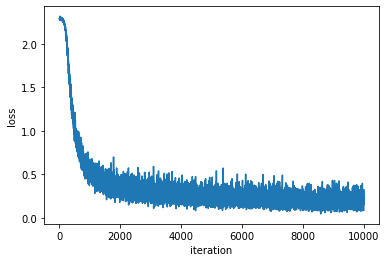

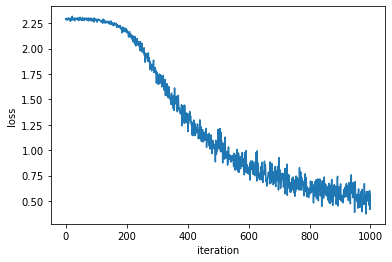

In [47]:
# 손실함수의 값 변화 그래프
x = np.arange(iters_num)

plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(x,train_loss_list)
plt.show()

print()
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(x[:1000],train_loss_list[:1000])
plt.show()

In [64]:
import numpy as np
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

# train data, test data를 불러옴
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True, flatten = True) 

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

# hyperparameter
num_epochs = 17
iters_num = 10000 # 훈련 반복 횟수
train_size = x_train.shape[0] # 훈련 데이터의 개수
batch_size = 100 # 미니배치의 크기
learning_rate = 0.1

train_loss_list = [] # 훈련 중 loss 를 계산해서 넣을 리스트
train_acc_list = [] # 1 에폭마다 train data에 대한 정확도를 계산해서 넣을 리스트
test_acc_list = [] # 1 에폭마다 test data에 대한 정확도를 계산해서 넣을 리스트

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size , 1) 

for i in range(iters_num): # 설정한 훈련 반복 횟수만큼
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # 0~59999 중 100개 선택
    x_batch = x_train[batch_mask] # 배치 사이즈만큼 train data의 입력
    t_batch = t_train[batch_mask] # 배치 사이즈만큼 train data의 정답

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) 
    # grad = network.numerical_gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'): # 각 가중치마다 갱신 해줘야 함
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch) # loss 계산
    train_loss_list.append(loss) # 그래프를 그리기 위해 리스트에 담는다.

    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) # train data 전체에 대한 acc
        test_acc = network.accuracy(x_test, t_test) # test data 전체에 대한 acc
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"[epoch : {int(i//iter_per_epoch)} / {num_epochs}]  train acc, test acc | {train_acc}, {test_acc}")

[epoch : 0 / 17]  train acc, test acc | 0.09871666666666666, 0.098
[epoch : 1 / 17]  train acc, test acc | 0.7718, 0.7812
[epoch : 2 / 17]  train acc, test acc | 0.8749, 0.8787
[epoch : 3 / 17]  train acc, test acc | 0.8986166666666666, 0.9021
[epoch : 4 / 17]  train acc, test acc | 0.9076333333333333, 0.9118
[epoch : 5 / 17]  train acc, test acc | 0.9149, 0.9178
[epoch : 6 / 17]  train acc, test acc | 0.9194, 0.9221
[epoch : 7 / 17]  train acc, test acc | 0.9244833333333333, 0.9254
[epoch : 8 / 17]  train acc, test acc | 0.9281, 0.9306
[epoch : 9 / 17]  train acc, test acc | 0.9298, 0.9316
[epoch : 10 / 17]  train acc, test acc | 0.9339, 0.9348
[epoch : 11 / 17]  train acc, test acc | 0.9366666666666666, 0.9371
[epoch : 12 / 17]  train acc, test acc | 0.9383666666666667, 0.9389
[epoch : 13 / 17]  train acc, test acc | 0.9408666666666666, 0.9411
[epoch : 14 / 17]  train acc, test acc | 0.9427166666666666, 0.9422
[epoch : 15 / 17]  train acc, test acc | 0.9452666666666667, 0.945
[epoch 

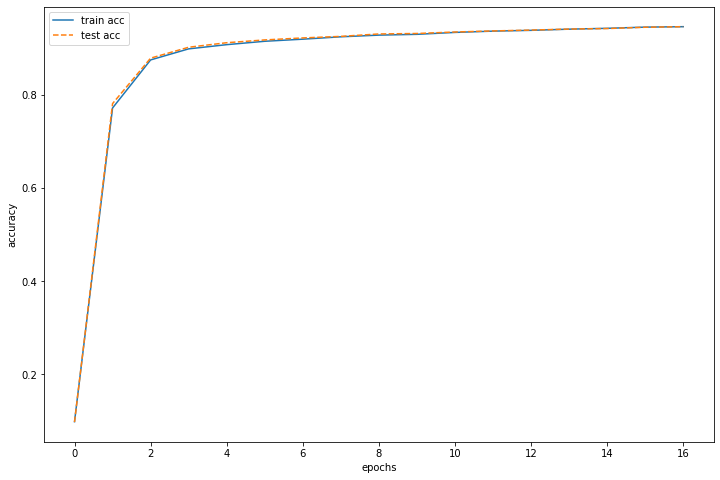

In [67]:
# 정확도의 값 변화 그래프
x = np.arange(num_epochs)

plt.figure(figsize=(12,8))
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.plot(x, train_acc_list, label = 'train acc')
plt.plot(x, test_acc_list, '--', label = 'test acc')
plt.legend()
plt.show()